In [2]:
import numpy as np
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
from generator_functions import random_uni_points_in_ball
from visualizations import plot_avkersize_conv, plot_times_comput, plot_wckersize_conv
from accuracy_bounds.inverseproblems.feasible_sets import compute_feasible_set_linear_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute import worstcase_kernelsize, worstcase_kernelsize_sym, average_kernelsize, average_kernelsize_sym
from accuracy_bounds.inverseproblems.utils import apply_forwardmodel
from accuracy_bounds.inverseproblems.kersize_compute_dataloader import worstcase_kernelsize_appartenance, average_kernelsize_appartenance, target_distances_cuda_V2
from accuracy_bounds.inverseproblems.feasible_sets_dataloader import feasible_appartenance_additive_noise_dataloader_cuda, feasible_appartenance_additive_noise_cuda 
from accuracy_bounds.inverseproblems.utils import torch_sparse_to_scipy_csr, torch_csr_to_scipy


# Tests

## Toy example 1 : 3D ball

In [3]:

# Toy example 1
num_points = 3000
radius = 2
center = (0,0,0)
dim = 3
epsilon=1e-1
seed = 43

# Toy forward operator
A = np.diag([1, 1, 0])  # Transformation matrix


target_data = random_uni_points_in_ball(num_points=num_points, radius=radius+epsilon, center=center, dim=3)   
input_data = apply_forwardmodel(A, target_data)



#analytical wc kersize for ball around 0 with radius r+epsilon
wc_kernel_size_analytical = 2*radius+2*epsilon
#analytical av kersize for ball around 0 with radius r+epsilon sampled with uniform distribution
av_kernel_size_analytical = np.multiply((radius+epsilon),np.power(1/3,1/2))

# Distance measure
p_1=2
p_2=2
# Kernel Size order
p=2



# Set the range of k values
max_k = 1000
input_target_pairs = 3000

# Step 1: Compute feasible sets from the linear forward model and data:
feasible_sets_list = []
for y in input_data[:input_target_pairs]:
    feas_set_y = compute_feasible_set_linear_forwardmodel(A, y, target_data[:input_target_pairs], p_2, epsilon)
    feasible_sets_list.append(feas_set_y)

### Worst case Kersize with symetric assumption, without parallelization

100%|██████████| 100/100 [00:04<00:00, 20.63it/s]


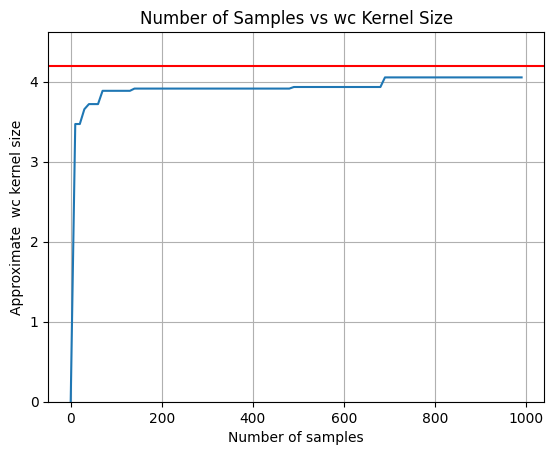

Total Max Kernel Size: 4.053991276374004
Analytical Kernel Size: 4.2
Relative Error: -0.034763981815713475


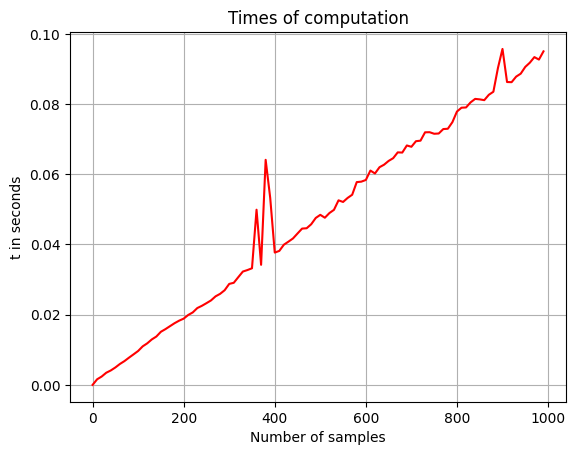

The last kernel size computation took 0.095009 seconds


In [6]:
# Step 2: Compute worst-case kernel sizes:
worstcase_kersize = worstcase_kernelsize(feasible_sets_list, p_1, p)

worstcase_kersize_list = []
times_comput = []
iterations = range(0,max_k-1, 10)

for k in tqdm(iterations):
    t0 = time.time()
    worstcase_kersize =  worstcase_kernelsize(feasible_sets_list[:k], p_1, p)
    worstcase_kersize_list.append(worstcase_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize, worstcase_kersize_list, wc_kernel_size_analytical, list(iterations))

plot_times_comput(list(iterations), times_comput)


100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


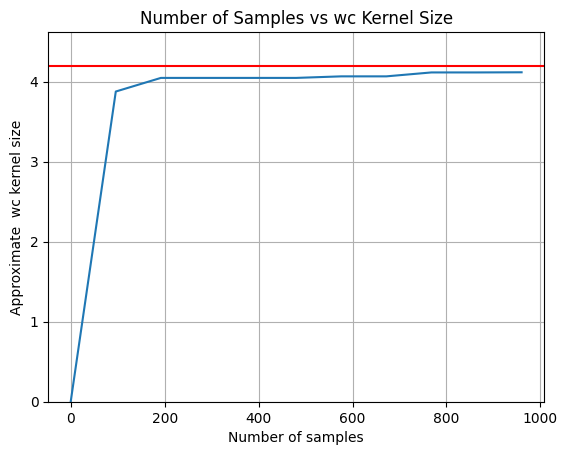

Total Max Kernel Size: 4.1179260210632815
Analytical Kernel Size: 4.2
Relative Error: -0.01954142355636158


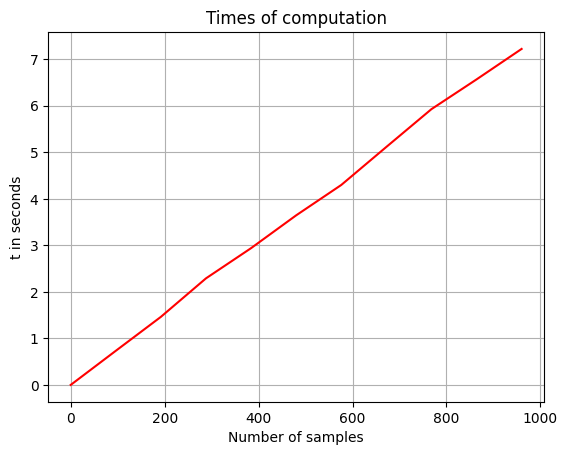

The last kernel size computation took 7.222062 seconds


In [8]:
# Step 2: Compute worst-case kernel sizes with symmetry assumption:
worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:input_target_pairs], target_data, p_1, p_2, p, 2*epsilon)

worstcase_kersize_sym_list = []
times_comput = []
iterations = range(0,max_k-1, 96)
for k in tqdm(iterations):
    t0 = time.time()
    worstcase_kersize_sym = worstcase_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    worstcase_kersize_sym_list.append(worstcase_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_wckersize_conv(worstcase_kersize_sym, worstcase_kersize_sym_list, wc_kernel_size_analytical, list(iterations))
plot_times_comput(list(iterations), times_comput)

### Worst-case kernel size, parallelized

  0%|          | 0/13 [00:00<?, ?it/s]

  8%|▊         | 1/13 [00:02<00:29,  2.43s/it]

 15%|█▌        | 2/13 [00:07<00:44,  4.06s/it]

 23%|██▎       | 3/13 [00:16<01:03,  6.32s/it]

 31%|███       | 4/13 [00:28<01:18,  8.67s/it]

 38%|███▊      | 5/13 [00:45<01:31, 11.47s/it]

 46%|████▌     | 6/13 [01:04<01:37, 13.98s/it]

 54%|█████▍    | 7/13 [01:27<01:42, 17.06s/it]

 62%|██████▏   | 8/13 [01:53<01:39, 19.85s/it]

 69%|██████▉   | 9/13 [02:21<01:29, 22.47s/it]

 77%|███████▋  | 10/13 [02:52<01:14, 24.98s/it]

 85%|████████▍ | 11/13 [03:28<00:56, 28.35s/it]

 92%|█████████▏| 12/13 [04:10<00:32, 32.66s/it]

100%|██████████| 13/13 [04:54<00:00, 22.64s/it]


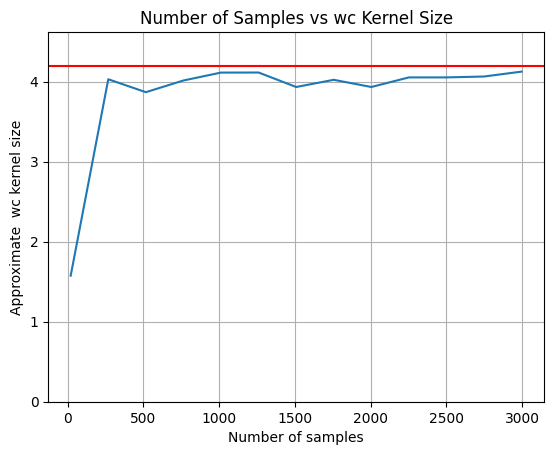

Total Max Kernel Size: 4.126347813359756
Analytical Kernel Size: 4.2
Relative Error: -0.01753623491434375


In [13]:
max_k = 3000
batch_size = 100
wc_kersizes = []
times_comput_FA = []
times_comput_WC = []

iterations = range(20,max_k,248)
for k in tqdm(iterations):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasible_appartenance_additive_noise_dataloader_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= epsilon)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX = target_distances_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    wc_kersize_k = worstcase_kernelsize_appartenance(distsXX, feasible_appartenance)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_WC.append(t2-t1)
    wc_kersizes.append(wc_kersize_k)

wc_kersizef = wc_kersizes[-1]

plot_wckersize_conv(wc_kersizef, wc_kersizes, wc_kernel_size_analytical, list(iterations))



### Average kernel size

100%|██████████| 100/100 [00:04<00:00, 21.98it/s]


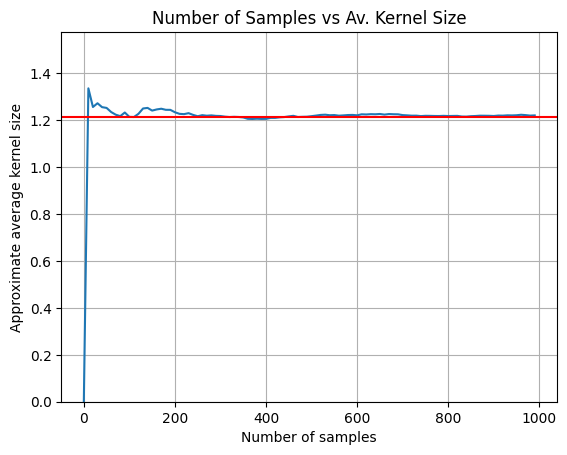

Total Max Kernel Size: 1.2210869441812149
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.00713553703851701


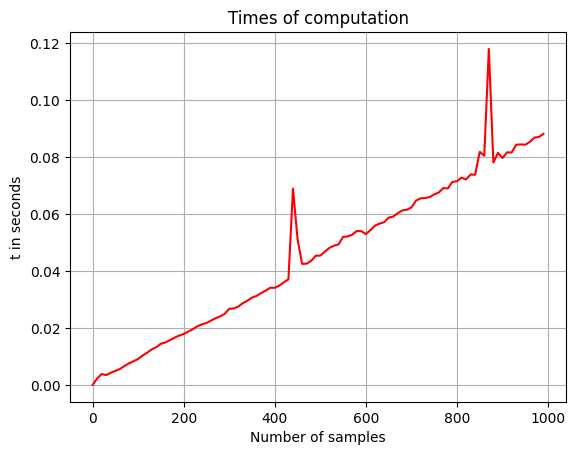

The last kernel size computation took 0.088178 seconds


In [10]:
max_k = 1000
# Step 2: Compute average kernel sizes:
average_kersize = average_kernelsize(feasible_sets_list, p_1, p)

average_kersize_list = []
times_comput = []

iterations = range(0,max_k,10)
for k in tqdm(iterations):
    t0 = time.time()
    average_kersize =  average_kernelsize(feasible_sets_list[:k], p_1, p)
    average_kersize_list.append(average_kersize)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize,average_kersize_list, av_kernel_size_analytical, list(iterations))
plot_times_comput(list(iterations), times_comput)

100%|██████████| 34/34 [02:15<00:00,  3.98s/it]


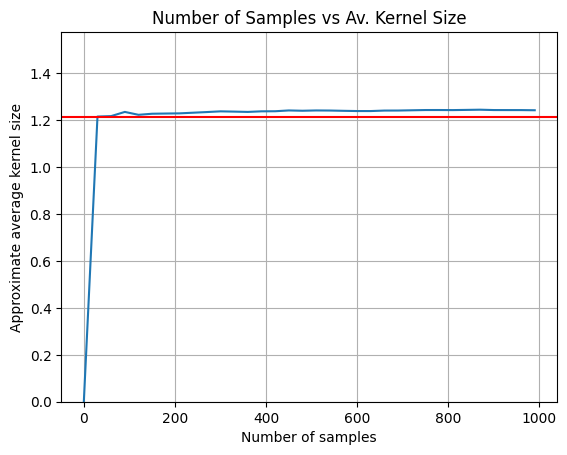

Total Max Kernel Size: 1.2429966258001592
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.025206337867883465


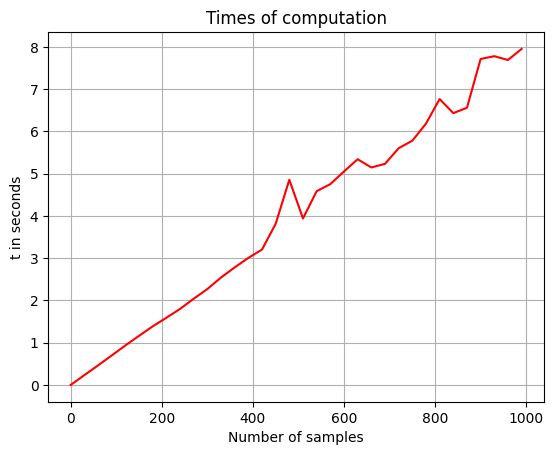

The last kernel size computation took 7.953368 seconds


In [11]:
# Step 2: Compute average symmetric kernel sizes:
average_kersize_sym = average_kernelsize_sym(A, input_data, target_data, p_1, p_2, p, epsilon)

average_kersize_sym_list = []
times_comput = []
iterations = range(0,max_k, 30)
for k in tqdm(iterations):
    t0 = time.time()
    average_kersize_sym =  average_kernelsize_sym(A, input_data[:k], target_data, p_1, p_2, p, epsilon)
    average_kersize_sym_list.append(average_kersize_sym)
    t1 = time.time()
    times_comput.append(t1-t0)

plot_avkersize_conv(average_kersize_sym,average_kersize_sym_list, av_kernel_size_analytical,list(iterations))
plot_times_comput(list(iterations), times_comput)

### Average kernel size, parallelized

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:00<00:06,  2.17it/s]

 13%|█▎        | 2/15 [00:05<00:37,  2.88s/it]

 20%|██        | 3/15 [00:14<01:10,  5.89s/it]

 27%|██▋       | 4/15 [00:28<01:40,  9.17s/it]

 33%|███▎      | 5/15 [00:49<02:14, 13.43s/it]

 40%|████      | 6/15 [01:20<02:55, 19.49s/it]

 47%|████▋     | 7/15 [02:00<03:29, 26.18s/it]

 53%|█████▎    | 8/15 [02:52<04:00, 34.42s/it]

 60%|██████    | 9/15 [04:00<04:28, 44.76s/it]

 67%|██████▋   | 10/15 [05:27<04:49, 57.90s/it]

 73%|███████▎  | 11/15 [07:02<04:37, 69.26s/it]

 80%|████████  | 12/15 [08:51<04:03, 81.24s/it]

 87%|████████▋ | 13/15 [11:05<03:14, 97.34s/it]

 93%|█████████▎| 14/15 [13:48<01:57, 117.09s/it]

100%|██████████| 15/15 [17:13<00:00, 68.87s/it] 


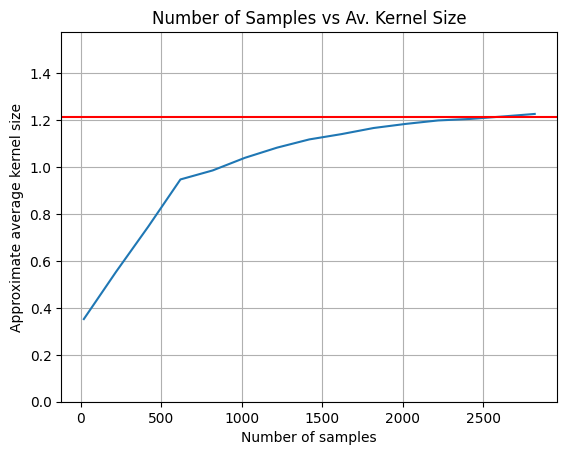

Total Max Kernel Size: 1.2272547810599952
Analytical Kernel Size: 1.2124355652982142
Relative Error: 0.012222683156062026


In [12]:
max_k = 3000
batch_size = 10
av_kersizes = []
times_comput_FA = []
times_comput_AV = []

iterations = range(20,max_k,200)

for k in tqdm(iterations):
    input_data_k = input_data[0:k,:]
    target_data_k = target_data[0:k,:]
    input_loader1 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    input_loader2 = DataLoader(input_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader1 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)
    target_loader2 = DataLoader(target_data_k, batch_size=batch_size, num_workers=batch_size, drop_last=False)   

    t0 = time.time()
    feasible_appartenance = feasible_appartenance_additive_noise_dataloader_cuda(input_loader1, input_loader2, p_Y=p_2, epsilon= epsilon)
    feasible_appartenance = feasible_appartenance.to(dtype=torch.float32).to_sparse_coo()

    t1 = time.time()
    distsXX = target_distances_cuda_V2(target_loader1, feasible_appartenance, p_X=p_1, batchsize= k)
    
    
    feasible_appartenance = torch_csr_to_scipy(feasible_appartenance.cpu().to_sparse_csr())
    distsXX = torch_sparse_to_scipy_csr(distsXX)

    av_kersize_k = average_kernelsize_appartenance(distsXX, feasible_appartenance, p_X=2)
    t2 = time.time()
    times_comput_FA.append(t1-t0)
    times_comput_AV.append(t2-t1)
    av_kersizes.append(av_kersize_k)

av_kersizef = av_kersizes[-1]

plot_avkersize_conv(av_kersizef, av_kersizes, av_kernel_size_analytical, list(iterations))